In [1]:
######################################################################
# N.B. Requires python environment with packages installed and #
# This script requires hard coded links #
# #
# Loads Phylobayes formatted trees and analyzes node ages #
# #
# © MIT EAPS Fournier Lab Jack G. Payette E: payette@mit.edu #
# #
######################################################################

In [2]:
import ete3
import pandas as pd
import re
import multiprocessing
import itertools
import random
import collections
import operator
import os
from scipy import stats

In [3]:
import numpy as np
#import pymc3
import seaborn as sns
import arviz
from matplotlib import pyplot as plt
from matplotlib.ticker import(MultipleLocator,FormatStrFormatter,AutoMinorLocator)
# Data stored to disk using pickle
import pickle as pkl

In [4]:
#Example installation call -- you may need to use pip,pip3,conda,miniconda t
#
# ! pip install arviz
# returns: Requirement already satisfied: arviz in /home/payette/.conda/env
#
# module add engaging/anaconda/2.3.0
# conda env list
# conda activate py37
#

In [5]:
#################
# Function defs #
#################

In [6]:
def get_node_age_from_descendants(tree,descendants):
    node=tree.get_common_ancestor(descendants)
    return(node.support)

In [7]:
def get_ci_of_the_mean(data, confidence=0.95):
    degrees_of_freedom = len(data) - 1
    tailed_alpha = (1 - confidence) / 2
    t_stats      = stats.t.ppf(tailed_alpha, degrees_of_freedom)
    std_err      = np.std(data) / np.sqrt( degrees_of_freedom )
    data_mean    = np.mean(data)
    return(data_mean - abs(t_stats * std_err), data_mean + abs(t_stats * std_err))

In [8]:
#BASIC CODE BLOCK!!! **LOAD TREES*** New code to read each line
def LoadTrees(chronogram_filename):
    #os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")
    posterior_trees = []
    for line in open(chronogram_filename).readlines():
        posterior_trees.append(ete3.Tree(line, format=0,quoted_node_names=False))
        #NOTE NODE.SUPPORT = NODE AGE ESTIMATE, NODE.DIST = BRANCH LENGTH
        #DEBUG: print(line)
    return(posterior_trees)
#Dec-19-2019
def LoadTrees1(chronogram_filename):
    #os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")
    posterior_trees = []
    for line in open(chronogram_filename).readlines():
        posterior_trees.append(ete3.Tree(line, format=1,quoted_node_names=False)) #for single chronogram format
        #NOTE NODE.SUPPORT = NODE AGE ESTIMATE, NODE.DIST = BRANCH LENGTH
        #DEBUG: print(line)
    return(posterior_trees)

In [9]:
# Start initializing routine and tree diagnostics
# Load guide tree & label tree
# N.B. guide Tree is not in use in this script.
# ASSUMPTION: ALL DATEDISTS HAVE THE SAME TOPOLOGY
# Trees needed for getAges function

In [10]:
os.chdir('modeldata')

In [11]:
ML_tree=ete3.Tree('sat_combined_full_run12_edited_subsampled401_removegaps_09092024_EDITRMCamp.phy.treefile.MADrooted.rooted',format=1)

In [12]:
ML_bootstrap_tree=ete3.Tree('sat_combined_full_run12_edited_subsampled401_removegaps_09092024_EDITRMCamp.phy.treefile',format=1)

In [13]:
# Load reference label trees
guide_tree = ete3.Tree('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.labels')
phylo_bayes_named_tree = ete3.Tree('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.labels',
                                   format=1)

In [14]:
print(guide_tree)


         /-KAJ8905014
        |
        |      /-KAK1864454
      /-|   /-|
     |  |  |  |   /-XP_0057136
     |  |  |   \-|
     |   \-|      \-KAI0560194
     |     |
     |     |   /-XP_0057086
   /-|      \-|
  |  |         \-KAA8499558
  |  |
  |  |      /-KAG6548791
  |  |   /-|
  |  |  |  |   /-KAH7427003
  |  |  |   \-|
  |   \-|     |   /-KAJ3679820
  |     |      \-|
  |     |         \-KAG2321429
  |     |
  |      \-GAQ84400_1
  |
  |            /-886293_Sin
  |         /-|
  |        |   \-575540_Iso
  |        |
  |      /-|      /-XP_0618104
  |     |  |   /-|
  |     |  |  |   \-926550_CLD
  |     |  |  |
  |     |   \-|      /-357808_Ros
  |     |     |   /-|
  |     |     |  |   \-324602_Ca1
  |     |      \-|
  |     |        |   /-380749_HY0
  |     |         \-|
  |     |            \-224324_aq_
  |     |
  |     |      /-767434_Fra
  |     |     |
  |     |     |      /-637389_Aca
  |     |   /-|   /-|
  |     |  |  |  |   \-243159_AFE
  |     |  |  |  |
  |    

In [15]:
#select the first TreeNode object upon traversing the tree in ete and check if is_root?
ete3.TreeNode.is_root(next(guide_tree.traverse()))

True

In [16]:
#Use the ete describe function upon traversing the tree in ete and check if is_root?
ete3.TreeNode.describe(next(guide_tree.traverse()))

Number of leaf nodes:	401
Total number of nodes:	801
Rooted:	Yes
Most distant node:	MBN2156680
Max. distance:	3556.509100


In [17]:
# Load PB label tree
# This is the important label tree that will be the PRIMARY PK
# Use with getAges, loadAges, for the target_node_age object and trees loaded from datedists

In [18]:
print(phylo_bayes_named_tree)


         /-KAJ8905014
        |
        |      /-KAK1864454
      /-|   /-|
     |  |  |  |   /-XP_0057136
     |  |  |   \-|
     |   \-|      \-KAI0560194
     |     |
     |     |   /-XP_0057086
   /-|      \-|
  |  |         \-KAA8499558
  |  |
  |  |      /-KAG6548791
  |  |   /-|
  |  |  |  |   /-KAH7427003
  |  |  |   \-|
  |   \-|     |   /-KAJ3679820
  |     |      \-|
  |     |         \-KAG2321429
  |     |
  |      \-GAQ84400_1
  |
  |            /-886293_Sin
  |         /-|
  |        |   \-575540_Iso
  |        |
  |      /-|      /-XP_0618104
  |     |  |   /-|
  |     |  |  |   \-926550_CLD
  |     |  |  |
  |     |   \-|      /-357808_Ros
  |     |     |   /-|
  |     |     |  |   \-324602_Ca1
  |     |      \-|
  |     |        |   /-380749_HY0
  |     |         \-|
  |     |            \-224324_aq_
  |     |
  |     |      /-767434_Fra
  |     |     |
  |     |     |      /-637389_Aca
  |     |   /-|   /-|
  |     |  |  |  |   \-243159_AFE
  |     |  |  |  |
  |    

In [19]:
ete3.TreeNode.is_root(next(phylo_bayes_named_tree.traverse()))

True

In [20]:
ete3.TreeNode.describe(next(phylo_bayes_named_tree.traverse()))

Number of leaf nodes:	401
Total number of nodes:	801
Rooted:	Yes
Most distant node:	MBN2156680
Max. distance:	3556.509100


In [21]:
%%capture
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)

In [22]:
#%%capture
internal_node_names=[]
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)
         internal_node_names.append(node.name)

401
402
407
408
409
410
411
403
404
405
406
412
702
703
709
704
708
705
707
706
710
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
711
737
738
739
740
752
753
741
751
742
743
744
746
749
750
747
748
745
754
785
755
756
757
758
781
783
784
782
759
778
780
779
760
761
776
777
762
772
773
774
775
763
770
771
764
765
767
769
768
766
712
735
736
713
714
715
724
716
717
719
718
720
721
722
723
725
726
734
727
733
728
729
730
731
732
413
414
415
421
416
417
418
419
420
422
695
696
697
698
699
700
701
423
693
694
424
425
655
658
659
656
657
426
621
622
623
624
625
626
631
632
633
634
635
627
628
629
630
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
427
620
428
610
611
612
613
614
615
616
617
618
619
429
607
608
609
430
528
529
530
531
532
533
534
539
540
535
536
538
537
541
542
603
604
605
606
543
592
593
599
600
601
602
594
598
595
596
597
544
580
581
588
589
590
582
583
584
585
586
587
591
545
567
576
577
578
579
568
569
570
574
575
571
572
573
546


In [23]:
#Possible internal nodes around which to fetch dates
print(internal_node_names,'Total:',len(internal_node_names))

['401', '402', '407', '408', '409', '410', '411', '403', '404', '405', '406', '412', '702', '703', '709', '704', '708', '705', '707', '706', '710', '786', '787', '788', '789', '790', '791', '792', '793', '794', '795', '796', '797', '798', '799', '800', '711', '737', '738', '739', '740', '752', '753', '741', '751', '742', '743', '744', '746', '749', '750', '747', '748', '745', '754', '785', '755', '756', '757', '758', '781', '783', '784', '782', '759', '778', '780', '779', '760', '761', '776', '777', '762', '772', '773', '774', '775', '763', '770', '771', '764', '765', '767', '769', '768', '766', '712', '735', '736', '713', '714', '715', '724', '716', '717', '719', '718', '720', '721', '722', '723', '725', '726', '734', '727', '733', '728', '729', '730', '731', '732', '413', '414', '415', '421', '416', '417', '418', '419', '420', '422', '695', '696', '697', '698', '699', '700', '701', '423', '693', '694', '424', '425', '655', '658', '659', '656', '657', '426', '621', '622', '623', '624'

In [24]:
### Tree relabel

In [25]:
#REPLACE PHYLO AND RANGER WITH CODE NAMED TREE
code_named_tree = ete3.Tree('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.labels',format=1)
ranger_node_named_tree = ete3.Tree('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.labels',format=1)
chronogram_node_named_tree = ete3.Tree('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.chronogram',format=1)

print(code_named_tree)


         /-KAJ8905014
        |
        |      /-KAK1864454
      /-|   /-|
     |  |  |  |   /-XP_0057136
     |  |  |   \-|
     |   \-|      \-KAI0560194
     |     |
     |     |   /-XP_0057086
   /-|      \-|
  |  |         \-KAA8499558
  |  |
  |  |      /-KAG6548791
  |  |   /-|
  |  |  |  |   /-KAH7427003
  |  |  |   \-|
  |   \-|     |   /-KAJ3679820
  |     |      \-|
  |     |         \-KAG2321429
  |     |
  |      \-GAQ84400_1
  |
  |            /-886293_Sin
  |         /-|
  |        |   \-575540_Iso
  |        |
  |      /-|      /-XP_0618104
  |     |  |   /-|
  |     |  |  |   \-926550_CLD
  |     |  |  |
  |     |   \-|      /-357808_Ros
  |     |     |   /-|
  |     |     |  |   \-324602_Ca1
  |     |      \-|
  |     |        |   /-380749_HY0
  |     |         \-|
  |     |            \-224324_aq_
  |     |
  |     |      /-767434_Fra
  |     |     |
  |     |     |      /-637389_Aca
  |     |   /-|   /-|
  |     |  |  |  |   \-243159_AFE
  |     |  |  |  |
  |    

In [26]:
# FUNCTION DEFINITION
#TO DO: ? PERHAPS ADJUST TO MAKE IT LIKE NODE AGE FUNCTIONS!
def get_internal_nodes(input_tree_ete3):
    #Given an ete3 Tree, Return internal nodes in preorder as a list
    temp_tree = input_tree_ete3.copy()
    internal_node_names = []
    for node in temp_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
            internal_node_names.append(node.name)
    return (internal_node_names)
print("'get_internal_nodes' function loaded")
#Example calls:
print(len(get_internal_nodes(code_named_tree)))

'get_internal_nodes' function loaded
400


In [27]:
#BASIC CODE BLOCK: Check to make sure the number of leaves is the same ~ similar tree topology
#PhyloBayesleaves = print(len(phylo_bayes_node_named_tree.get_leaves()))
RANGERleaves = print(len(code_named_tree.get_leaves()))
#assert [PhyloBayesleaves == RANGERleaves]
#Expect Result 170 leaves using .get_leaves()

#Check to make sure the number of internal nodes is the same ~ similar tree topology
#print(len(get_internal_nodes(phylo_bayes_node_named_tree)))
print(len(get_internal_nodes(code_named_tree)))    
#assert [len(get_internal_nodes(phylo_bayes_node_named_tree)) == len(get_internal_nodes(ranger_node_named_tree))]
#Expect Result 169 internal nodes using NOT .is_leaf()

401
400


In [28]:
#Store leaf names in list given a tree
def save_leaf_name(input_tree_ete3):
    leaf_names = []
    for node in input_tree_ete3.traverse():
        if node.is_leaf():
            leaf_names.append(node.name)
    return leaf_names
#Example calls:
#print(len(save_leaf_name(phylo_bayes_node_named_tree)))
print(len(save_leaf_name(code_named_tree)))

#Store internal names in list given tree
def save_node_name(input_tree_ete3):
    internal_node_names = []
    for node in input_tree_ete3.traverse():
        if not node.is_leaf():
            internal_node_names.append(node.name)
    return internal_node_names

#Example calls:
#save_node_name(phylo_bayes_node_named_tree)
#print(len(save_node_name(phylo_bayes_node_named_tree)))
#save_node_name(ranger_node_named_tree)
print(len(save_node_name(code_named_tree)))

401
400


In [29]:
### DEPRECATE!
#BASIC CODE BLOCK *** INTERNAL NODE NAMES KEY *** @temp_tree_internal_node_names
#PRE-ORDER TRAVERSAL ORDER USED!!!
temp_tree_internal_node_names = []
for node in code_named_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
             temp_tree_internal_node_names.append(node.name)
           #print(node.name)
#print(temp_tree_internal_node_names)

temp_tree_internal_node_names2 = []
for node in code_named_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
             temp_tree_internal_node_names2.append(node.name)
           #print(node.name)
#print(temp_tree_internal_node_names2)

#BUILD PHYLOBAYES NODE LABEL 2 RANGER NODE LABEL KEY

#Store temp internal node name lists -- REQUIRED FOR FUNCTIONS BELOW TO WORK
temp_tree_internal_node_names[:] = save_node_name(code_named_tree)
#print(temp_tree_internal_node_names[:])
node_index =pd.DataFrame(temp_tree_internal_node_names[0:])
node_index.rename(columns={node_index.columns[0]:"StandardNodeName"},inplace= True)

temp_tree_internal_node_names2[:] = save_node_name(code_named_tree)
#print(temp_tree_internal_node_names2[:])
node_index2=pd.DataFrame(temp_tree_internal_node_names2[0:])
node_index2.rename(columns={node_index2.columns[0]:"RangerNodeName"},inplace= True)

node_index_master= node_index.join(node_index2,how='left')
#print(node_index_master)
print(node_index_master.head())

### DEFINE FUNCTIONS!
def find_phylo_return_ranger_node(node_name_input):
    newdf = node_index_master[node_index_master.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['StandardNodeName']==node_name_input,'RangerNodeName'].values[0])

def find_ranger_return_phylo_node(node_name_input):
    newdf = node_index_master[node_index_master.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['RangerNodeName']==node_name_input,'StandardNodeName'].values[0])

#Example calls:
print("135 is",find_phylo_return_ranger_node('135')) #returns 170
print("135 is",find_ranger_return_phylo_node('135'))  #returns n1

#REMEBER KEY INDEX IN PYTHON STARTS WITH ZERO!~
#This is wrong: 171 is NOT equal to n127!!!
#print('This is wrong: 171 is NOT equal to n127!!!')

  StandardNodeName RangerNodeName
0              401            401
1              402            402
2              412            412
3              407            407
4              403            403
135 is 
135 is 


In [30]:
#Load data objects for ***TIP LABEL KEY*** @tip_key_df
#os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")

tip_key_df = pd.read_excel('SAT_TREE_TAXA_CALIBS.xlsx',usecols=['Code','TaxId','ShortName','FullName'])
print(tip_key_df.head())

#Debug and diagnostic
#tip_key_df['FullName']
tip_key_df.loc[[0],:]

         Code      TaxId                    ShortName  \
0  1537917_JU  1537917.0           1537917.JU82_09680   
1  990073_ATH   990073.0  990073.ATHU01000001_gene600   
2  749222_Nit   749222.0            749222.Nitsa_1667   
3  387092_NIS   387092.0              387092.NIS_0593   
4  326298_Sud   326298.0            326298.Suden_1489   

                              FullName  
0               Sulfuricurvum sp. MLSB  
1                Lebetimonas sp. JS170  
2  Nitratifractor salsuginis DSM 16511  
3            Nitratiruptor sp. SB155-2  
4  Sulfurimonas denitrificans DSM 1251  


,Code,TaxId,ShortName,FullName
0,1537917_JU,1537917.0,1537917.JU82_09680,Sulfuricurvum sp. MLSB


In [31]:
### These functions rely upon the previous tip_key_df

In [32]:
#Function which searches tip_key_df with a Short Name variable as input and a Full Name output w/ blank handler
#Debug: print(len(tip_key_df.loc[tip_key_df['ShortName']=='M_roseus','FullName'].values[0]))
def find_short_return_long_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['ShortName']==node_name_input,'FullName'].values[0])

#Example calls:
#find_short_return_long_name('M_roseus')
#find_short_return_long_name('Chl_377431')

#Function which searches tip_key_df with a Code variable as input and a Full Name output w/ blank handler
#Debug: print(len(tip_key_df.loc[tip_key_df['Dode']=='M_roseus','FullName'].values[0]))
#tip_key_df[tip_key_df.eq('SAMN02604006').any(1)]

def find_code_return_long_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['Code']==node_name_input,'FullName'].values[0])

    
def find_code_return_short_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['Code']==node_name_input,'ShortName'].values[0])

    
#investigate this behavior!
#find_code_return_long_name('Chl0') #returns 0 index/error?! because of use of .any(1) call??

#Example calls:
find_code_return_long_name('1537917_JU')

'Sulfuricurvum sp. MLSB'

In [33]:
# FIND CODE RETURN SHORTNAME

In [34]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = chronogram_node_named_tree.copy()

phylo_bayes_leaf_names_old = []
phylo_bayes_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            print(node.name)
            phylo_bayes_leaf_names_old.append(node.name)
            phylo_bayes_leaf_names_new.append(find_code_return_short_name(node.name))
            node.name=str(find_code_return_long_name(node.name))
            
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree_dates = code_named_tree.copy()
phylo_bayes_leaf_dates = []
phylo_bayes_node_names = []
for node in temp_tree_dates.traverse(strategy="preorder"):
         if not node.is_leaf():
            phylo_bayes_leaf_dates.append(node.dist)
            phylo_bayes_node_names.append(node.name)
#print(temp_tree_dates)
#print(phylo_bayes_leaf_dates)
print(phylo_bayes_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

KAJ8905014
KAK1864454
XP_0057136
KAI0560194
XP_0057086
KAA8499558
KAG6548791
KAH7427003
KAJ3679820
KAG2321429
GAQ84400_1
886293_Sin
575540_Iso
XP_0618104
926550_CLD
357808_Ros
324602_Ca1
380749_HY0
224324_aq_
767434_Fra
637389_Aca
243159_AFE
469371_Tbi
2002_JOEQ0
58123_JOFJ
561175_KB8
446468_Nda
269800_Tfu
1236902_AN
405948_SAC
390989_JOE
446470_Sna
1463821_JO
1869_MB27_
1121946_AU
XP_0127582
XP_0043388
XP_0021746
TID30620_1
KAI3646010
KAK1922150
KAI0692602
KAI5806891
KAI4275158
KAJ3181463
KAI9034119
KAI7865698
KAI8870440
KAF9584850
KAF9283768
RIB05711_1
CAJ0637853
XP_0141543
XP_0043491
KAA0154940
CAE7727485
KAH9260909
XP_0058413
KOO28507_1
KAG8469202
KAJ9453590
GBG34052_1
KAJ1410243
KAG7337429
XP_0058551
CBN77774_1
QDZ25634_1
KAK3250701
OUS43473_1
GAX73546_1
PRW57800_1
KAG1676086
GLI69646_1
KDD76481_1
CAD7701358
1501269_EW
1471522_JF
1471459_JF
1499499_EV
ABH09264_1
316278_Syn
69042_WH57
292564_Cya
32051_SynW
1280380_KR
518766_Rma
673862_BAB
1123399_AQ
227377_CBU
870187_Th1
1469245_J1

In [35]:
print(temp_tree)


         /-Rhodosorus marinus_2
        |
        |      /-Neopyropia yezoensis_2
      /-|   /-|
     |  |  |  |   /-Chondrus crispus_2
     |  |  |   \-|
     |   \-|      \-Gracilaria domingensis_2
     |     |
     |     |   /-Galdieria sulphuraria
   /-|      \-|
  |  |         \-Porphyridium purpureum_2
  |  |
  |  |      /-Marchantia paleacea
  |  |   /-|
  |  |  |  |   /-Ceratopteris richardii
  |  |  |   \-|
  |   \-|     |   /-Juncus effusus
  |     |      \-|
  |     |         \-Brassica carinata
  |     |
  |      \-Klebsormidium nitens
  |
  |            /-Singulisphaera acidiphila DSM 18658
  |         /-|
  |        |   \-Isosphaera pallida ATCC 43644
  |        |
  |      /-|      /-Nerophis lumbriciformis
  |     |  |   /-|
  |     |  |  |   \-Caldilinea aerophila DSM 14535 = NBRC 104270
  |     |  |  |
  |     |   \-|      /-Roseiflexus sp. RS-1
  |     |     |   /-|
  |     |     |  |   \-Chloroflexus aurantiacus J-10-fl_2
  |     |      \-|
  |     |        |   /-H

In [36]:
temp_tree.write(format=1, outfile="sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.shortname.treefile")

In [37]:
# FIND CODE RETURN LONGNAME

In [38]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = chronogram_node_named_tree.copy()

ranger_leaf_names_old = []
ranger_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            ranger_leaf_names_old.append(node.name)
            ranger_leaf_names_new.append(find_code_return_long_name(node.name))
            node.name=str(find_code_return_long_name(node.name))
            
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree_dates = ranger_node_named_tree.copy()
ranger_leaf_dates = []
ranger_node_names = []
for node in temp_tree_dates.traverse(strategy="preorder"):
         if not node.is_leaf():
            ranger_leaf_dates.append(node.dist)
            ranger_node_names.append(node.name)
#print(temp_tree_dates)
print(ranger_leaf_dates)
print(ranger_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

[0.0, 2101.19, 220.682, 171.3, 205.539, 326.391, 175.813, 686.03, 139.818, 122.499, 79.5831, 12.1096, 367.239, 165.013, 1240.29, 420.072, 700.789, 219.239, 478.945, 1210.8, 199.498, 237.838, 274.413, 1149.91, 905.561, 477.138, 102.526, 566.73, 73.7745, 506.973, 88.1802, 127.087, 362.339, 160.081, 182.747, 113.524, 64.494, 87.1539, 194.02, 610.03, 927.751, 136.93, 150.582, 284.567, 225.265, 50.6226, 283.443, 72.5299, 90.7993, 70.8874, 177.121, 47.2405, 340.646, 210.513, 903.044, 623.538, 283.295, 192.87, 293.404, 106.602, 67.5382, 89.5212, 143.248, 136.372, 62.8548, 160.886, 138.593, 80.4319, 96.4485, 92.2573, 46.6813, 107.277, 45.0585, 95.1271, 76.5412, 141.696, 76.1536, 194.875, 103.608, 402.768, 75.8383, 64.0645, 63.8423, 77.2763, 119.349, 213.145, 106.258, 439.991, 757.845, 88.0336, 161.401, 144.332, 164.262, 116.552, 89.9487, 252.943, 1807.72, 271.295, 191.643, 215.031, 165.512, 106.681, 217.138, 1193.01, 133.325, 578.35, 144.33, 739.616, 184.394, 286.673, 256.554, 125.768, 23.5025

In [39]:
temp_tree.write(format=1, outfile="sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.treefile")

In [40]:
####### REWRITE ML TREE ####

In [41]:
# FIND CODE RETURN LONG

In [42]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = ML_tree.copy()

ranger_leaf_names_old = []
ranger_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            ranger_leaf_names_old.append(node.name)
            ranger_leaf_names_new.append(find_code_return_long_name(node.name))
            node.name=str(find_code_return_long_name(node.name))
            #node.label=
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

#temp_tree_dates = ranger_node_named_tree.copy()
#ranger_leaf_dates = []
#ranger_node_names = []
#for node in temp_tree_dates.traverse(strategy="preorder"):
#         if not node.is_leaf():
#            ranger_leaf_dates.append(node.dist)
#            ranger_node_names.append(node.name)
#print(temp_tree_dates)
#print(ranger_leaf_dates)
#print(ranger_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

In [43]:
temp_tree.write(format=1, outfile="ML.treefile")

In [44]:
####### REWRITE ML BOOT TREE ####

In [45]:
# FIND CODE RETURN LONG

In [46]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = ML_bootstrap_tree.copy()

ranger_leaf_names_old = []
ranger_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            ranger_leaf_names_old.append(node.name)
            ranger_leaf_names_new.append(find_code_return_long_name(node.name))
            node.name=str(find_code_return_long_name(node.name))
            #node.label=
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

#temp_tree_dates = ranger_node_named_tree.copy()
#ranger_leaf_dates = []
#ranger_node_names = []
#for node in temp_tree_dates.traverse(strategy="preorder"):
#         if not node.is_leaf():
#            ranger_leaf_dates.append(node.dist)
#            ranger_node_names.append(node.name)
#print(temp_tree_dates)
#print(ranger_leaf_dates)
#print(ranger_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

In [47]:
temp_tree.write(format=1, outfile="ML_bootstrap.treefile")

In [48]:
##################
# Node labels selected for dates are hard coded!
##################
target_node_ages = {'401':[],  #ROOT
                    '412':[],  # ONE NODE ABOVE ROOT
                    '660':[],  #CROWN CYANO
                    '407':[],  #Rhodophyta
                    '403':[],  #Streptophyta
                    '740':[], #FUNGI
                    
                   }

In [49]:
print(target_node_ages) 

{'401': [], '412': [], '660': [], '407': [], '403': [], '740': []}


In [50]:
def getAges(posterior_trees,model_name):
    # Function inputs:
    # posterior_trees AKA datedist TREES
    # phylo_bayes_named_tree # hard coded
    # target_node_ages # hard coded
    # model_name
    # Careful the line below can take a long time. Use the target_node_ages code above to change the loop!!!

    # Weird way of indexing over these trees, but we don't care which trees we take
    post_tree_index=[]
    n=0
    for each in posterior_trees:
        post_tree_index.append(n)
        n=n+1
    posterior_trees
    print('Length of Datedist',len(posterior_trees))

    target_node_ages = {'401': [], #root
                        '412':[] #stem
                       }
    target_node_descendants = {}

    for node_name in target_node_ages:
        node = next(phylo_bayes_named_tree.iter_search_nodes(name=node_name))
        target_node_descendants[node_name] = node.get_leaf_names()

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])

    for tree_index, target_node in itertools.product(post_tree_index, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
                )
            )

    #Use this after the long run above
    with open(''+model_name+'_target_node_ages.pkl', 'wb') as out:
            pkl.dump(target_node_ages, out)

    return(target_node_ages)
    print('done')

In [51]:
def loadAges(model_name):
    with open(''+model_name+'_target_node_ages.pkl', 'rb') as into:  
        model_target_node_ages = pkl.load(into)
        #print('Length of Datedist',len(model_target_node_ages[:]))
    return(model_target_node_ages)

In [52]:
###############
### EXAMPLE:  #
###############

In [53]:
#C_ln_lg_rootcal = loadAges('rbcL_new_04212024_ln_lg_rootcal_post_sample.chronogram')
#C_ln_lg_rootcaluni_prior = loadAges('rbcL_new_04212024_ln_lg_rootcaluni_prior_sample.chronogram')

In [54]:
#Length of Datedist loaded
#len(ugam_lg_rootcal_post_ages['135'][0])
# Prints an list of node ages (or you can wrap it in an array)
# for a given node label, from a target_node_age dictionary
#print(ugam_lg_rootcal_post_ages['135'][0])

In [55]:
### Load

In [56]:
#ugam_all_euk_prior = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_prior.1_sample.datedist')

In [57]:
#ugam_all_euk_prior_ages = getAges(ugam_all_euk_prior,'ugam_all_euk_prior')

In [58]:
ugam_all_euk_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_allEuk_only_UGAM_noBD_post.1_sample.datedist')

In [59]:
ugam_all_euk_post_ages = getAges(ugam_all_euk_post,'ugam_all_euk_post')

Length of Datedist 100


In [60]:
### Plot (basic)

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


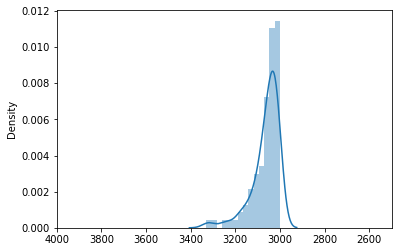

Root age Euk cals only ugam lg posterior (blue)


In [61]:
sns.distplot(ugam_all_euk_post_ages['401']) #BLUE
plt.xlim(4000,2500)
plt.show() 
print('Root age Euk cals only ugam lg posterior (blue)')

In [62]:
 ####

In [63]:
### LOAD Data: all models for All calibrations set (Root, Euk and Cyano)

In [64]:
sat_rootcal_ugam_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_only_UGAM_noBD_post.1_sample.datedist')

In [65]:
C_rootcal_UGAM_post_ages = getAges(sat_rootcal_ugam_post,'sat_rootcal_ugam_post')

Length of Datedist 100


In [66]:
sat_rootcal_cir_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_only_CIR_noBD_post.1_sample.datedist')

In [67]:
C_rootcal_CIR_post_ages = getAges(sat_rootcal_cir_post,'sat_rootcal_cir_post')

Length of Datedist 100


In [68]:
sat_rootcal_all_euk_ugam_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_allEuk_only_UGAM_noBD_post.1_sample.datedist')

In [69]:
sat_rootcal_all_euk_CIR_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_allEuk_only_CIR_noBD_post.1_sample.datedist')

In [70]:
C_euk_cals_UGAM_post_ages = getAges(sat_rootcal_all_euk_ugam_post,'sat_rootcal_all_euk_Cyano2_ugam_post')

Length of Datedist 100


In [71]:
C_euk_cals_CIR_post_ages = getAges(sat_rootcal_all_euk_CIR_post,'sat_rootcal_all_euk_Cyano2_CIR_post')

Length of Datedist 100


In [72]:
sat_rootcal_Cyano2_ugam_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_Cyano2_only_UGAM_noBD_post.1_sample.datedist')

In [73]:
sat_rootcal_Cyano2_CIR_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_Cyano2_only_CIR_noBD_post.1_sample.datedist')

In [74]:
C_Cyano_cals_UGAM_post_ages = getAges(sat_rootcal_Cyano2_ugam_post,'sat_rootcal_Cyano2_ugam_post')

Length of Datedist 100


In [75]:
C_Cyano_cals_CIR_post_ages = getAges(sat_rootcal_Cyano2_CIR_post,'sat_rootcal_Cyano2_CIR_post')

Length of Datedist 100


In [76]:
sat_rootcal_all_euk_Cyano2_ugam_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_UGAM_noBD_post.1_sample.datedist')

In [77]:
sat_rootcal_all_euk_Cyano2_CIR_post = LoadTrees('sat_sub401_rmgaps_09092024_lg_rootcal_Combined_allEuk_Cyano2_CIR_noBD_post.1_sample.datedist')

In [78]:
C_all_cals_UGAM_post_ages = getAges(sat_rootcal_all_euk_Cyano2_ugam_post,'sat_rootcal_all_euk_Cyano2_ugam_post')

Length of Datedist 100


In [79]:
C_all_cals_CIR_post_ages = getAges(sat_rootcal_all_euk_Cyano2_CIR_post,'sat_rootcal_all_euk_Cyano2_CIR_post')

Length of Datedist 100


In [80]:
# Demo plot of all models for crown age

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

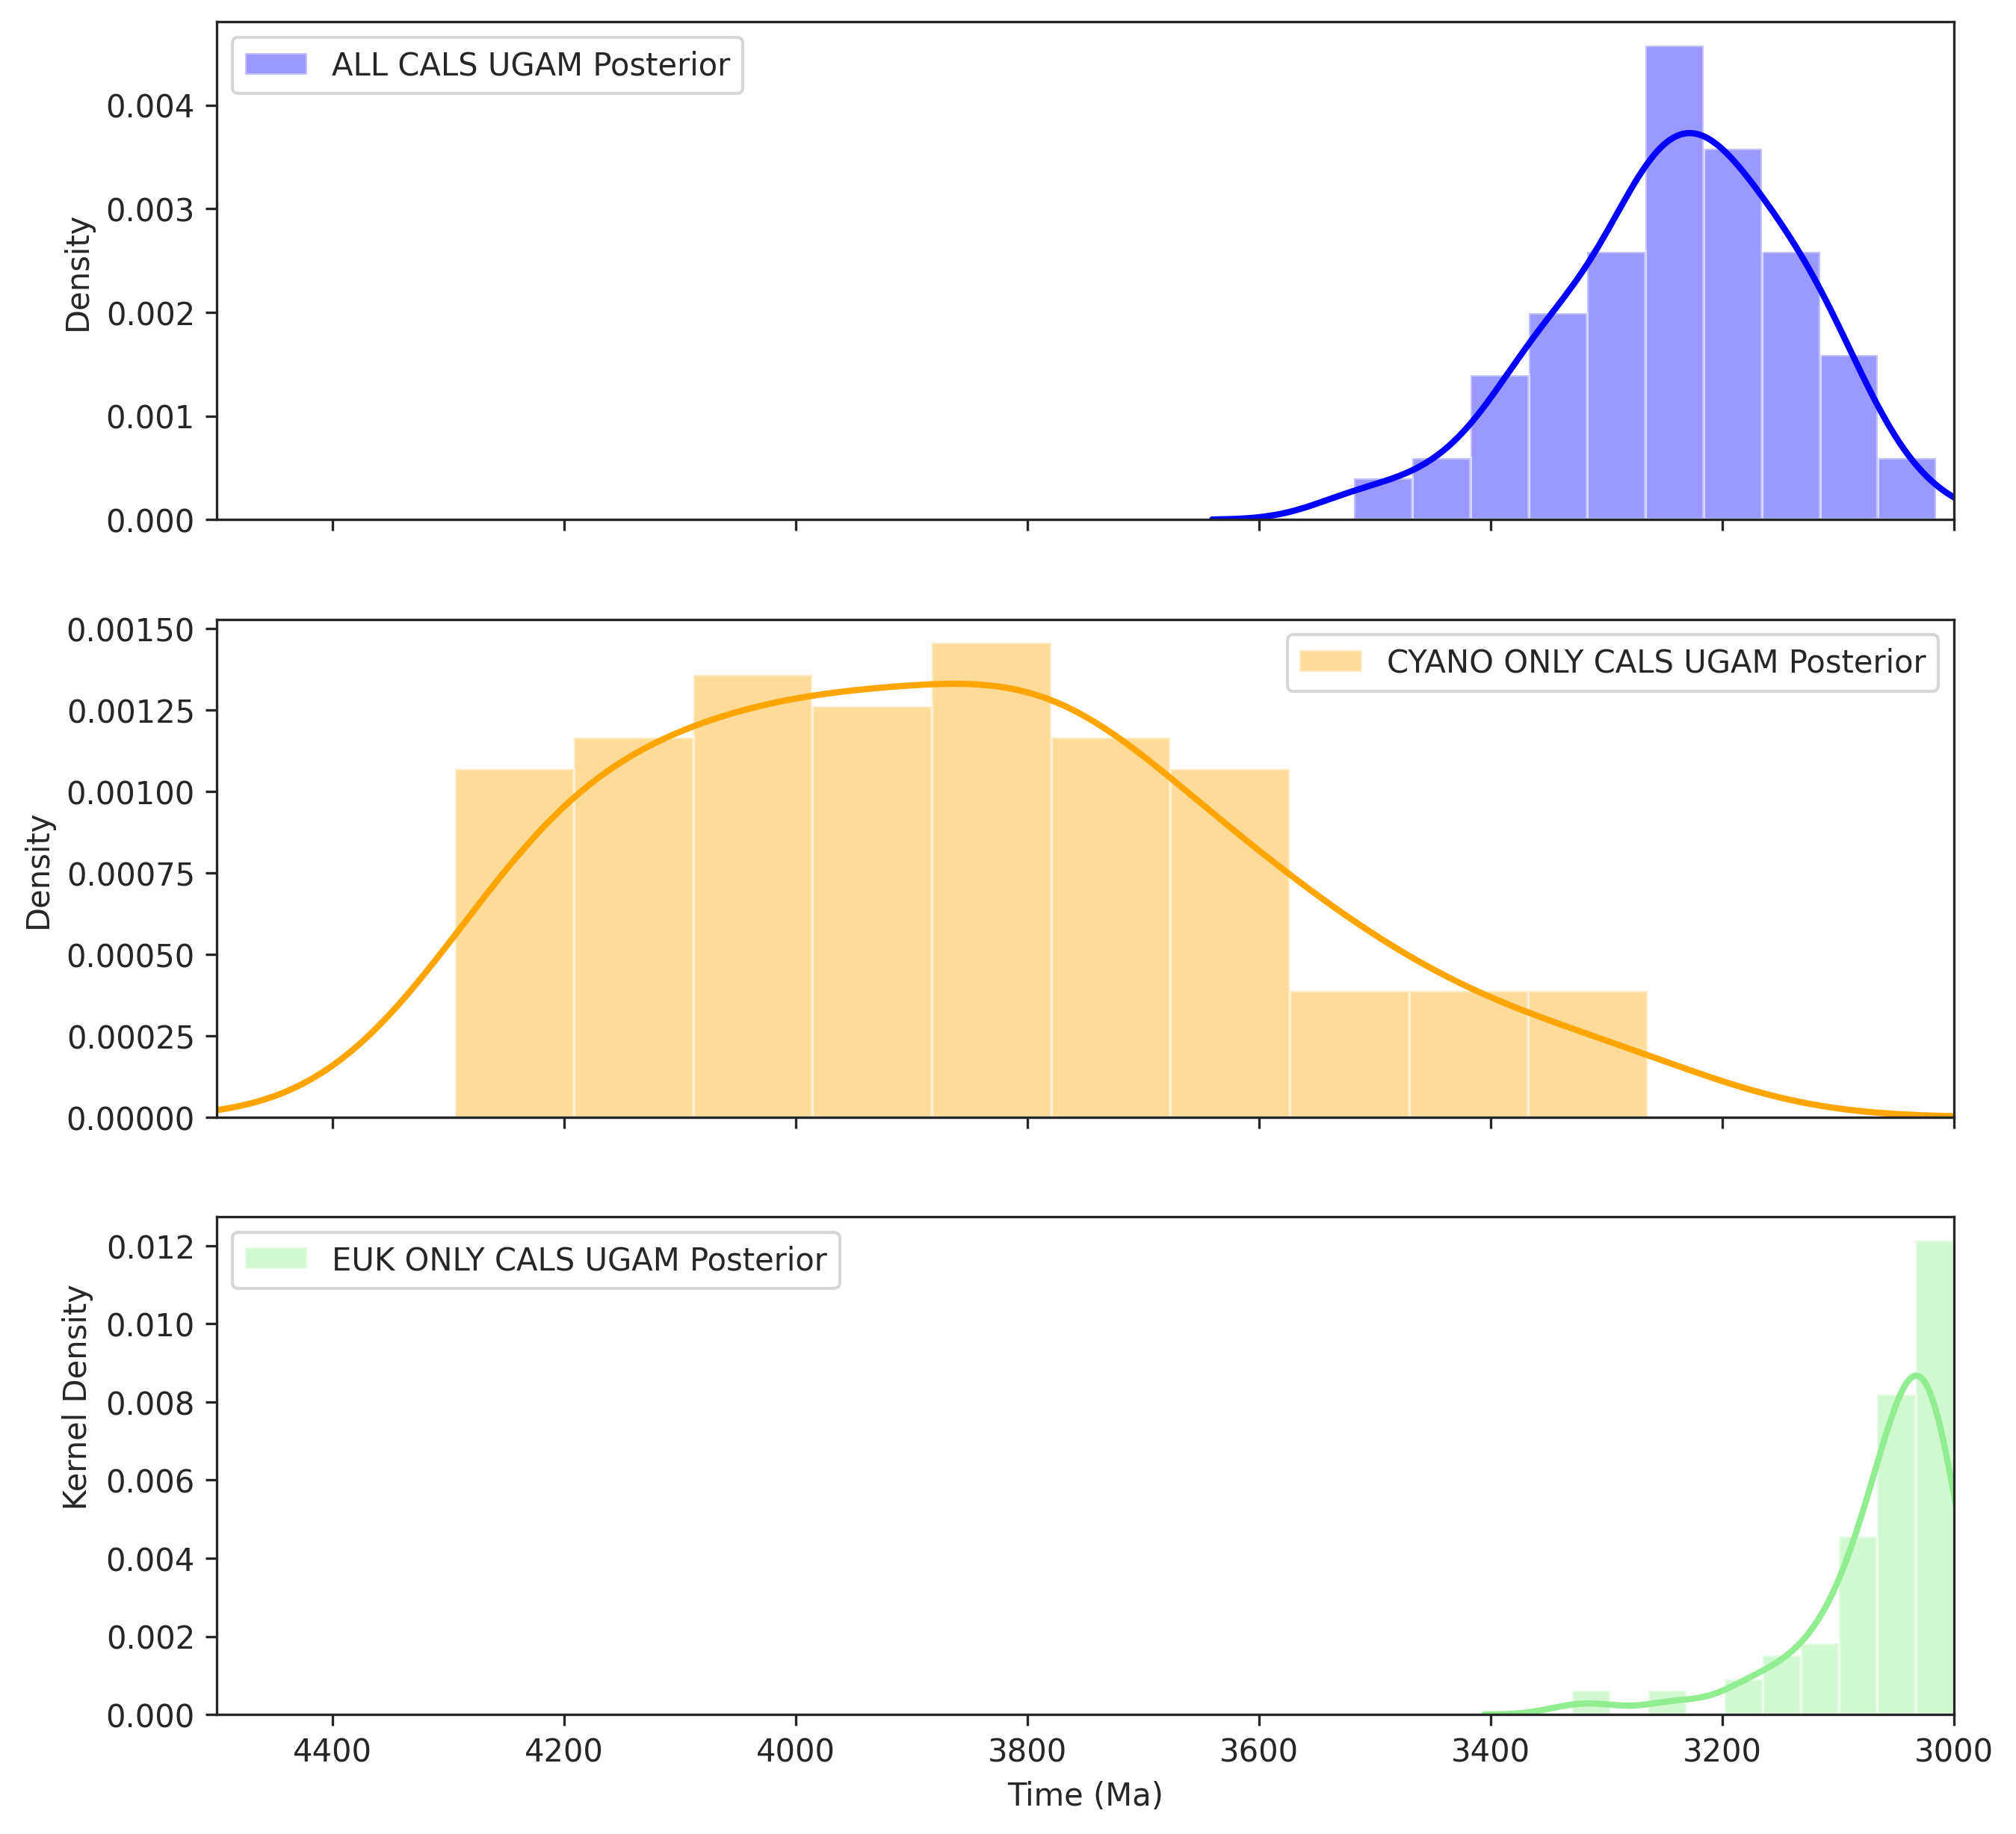

Sat Crown Age All Calibrations and All Models x Branch Rate Processes


In [81]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,3000)
sns.distplot(C_all_cals_UGAM_post_ages['401'], label="ALL CALS UGAM Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
axes[0].legend()
sns.distplot(C_Cyano_cals_UGAM_post_ages['401'], label="CYANO ONLY CALS UGAM Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
axes[1].legend()
sns.distplot(C_euk_cals_UGAM_post_ages['401'], label="EUK ONLY CALS UGAM Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.png", format="png")
print('Sat Crown Age All Calibrations and All Models x Branch Rate Processes')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

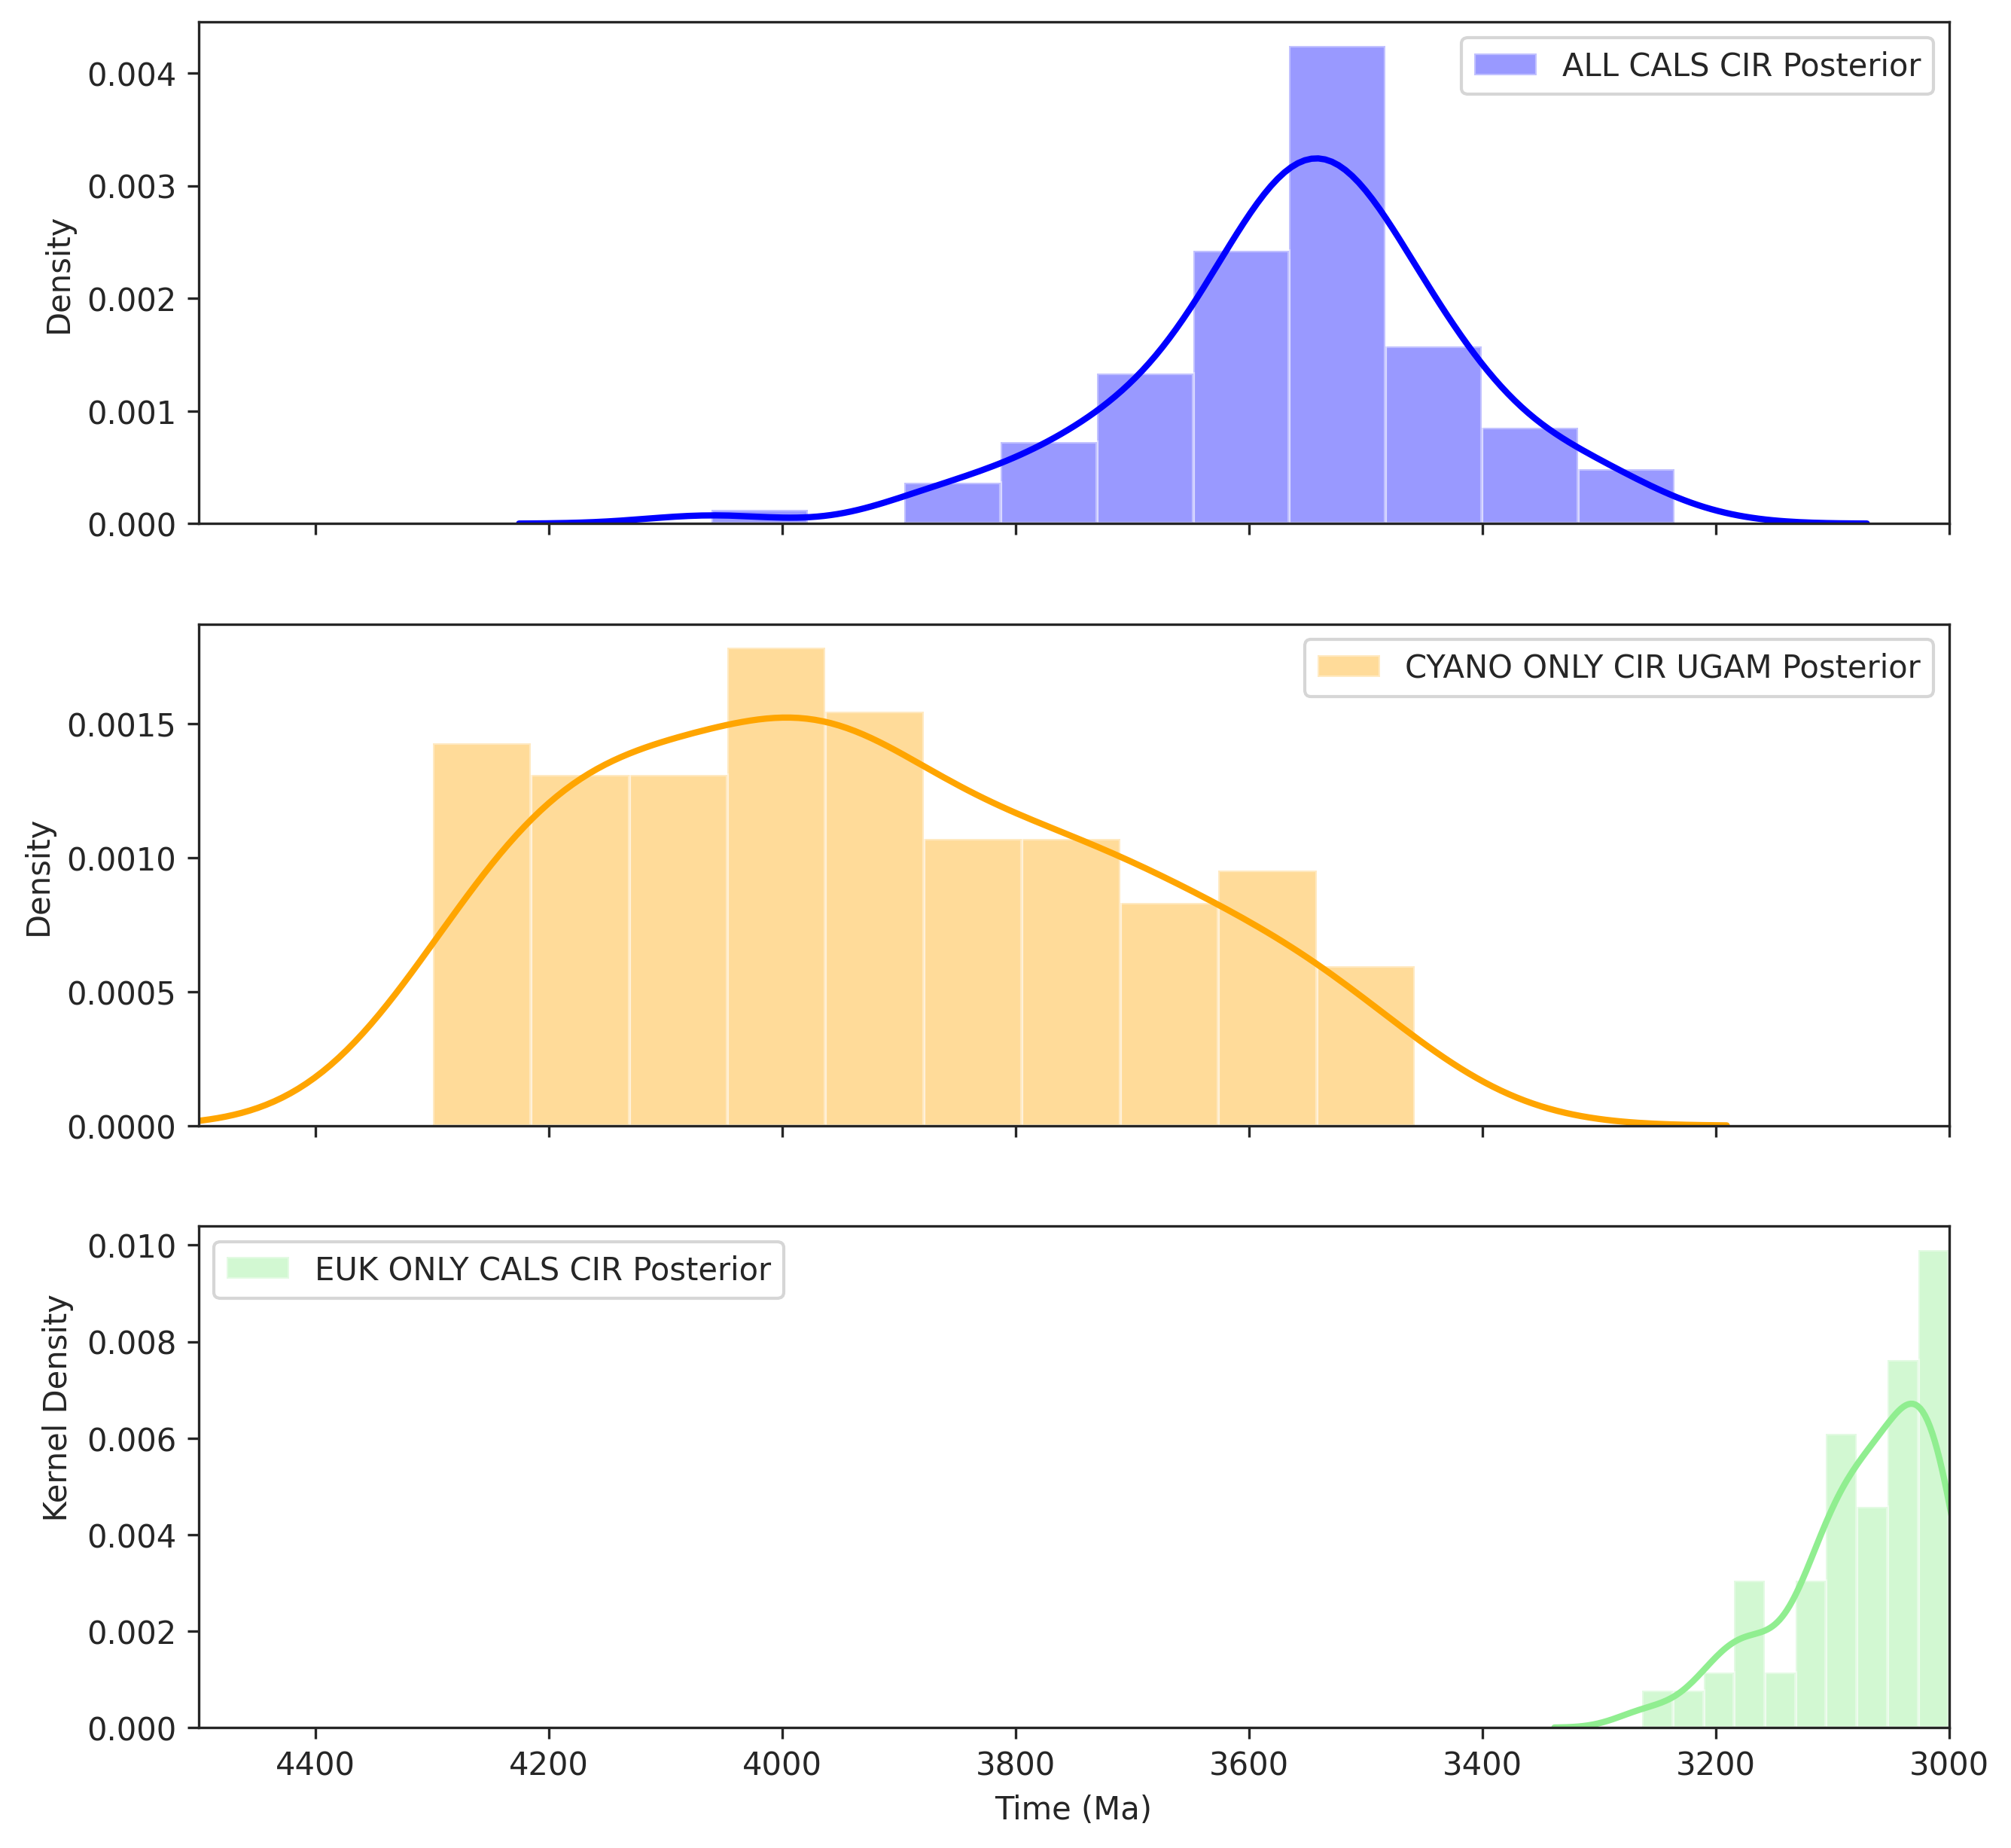

Sat Crown Age All Calibrations and All Models x Branch Rate Processes


In [82]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,3000)
sns.distplot(C_all_cals_CIR_post_ages['401'], label="ALL CALS CIR Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
axes[0].legend()
sns.distplot(C_Cyano_cals_CIR_post_ages['401'], label="CYANO ONLY CIR UGAM Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
axes[1].legend()
sns.distplot(C_euk_cals_CIR_post_ages['401'], label="EUK ONLY CALS CIR Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.png", format="png")
print('Sat Crown Age All Calibrations and All Models x Branch Rate Processes')

In [83]:
### Final Plot

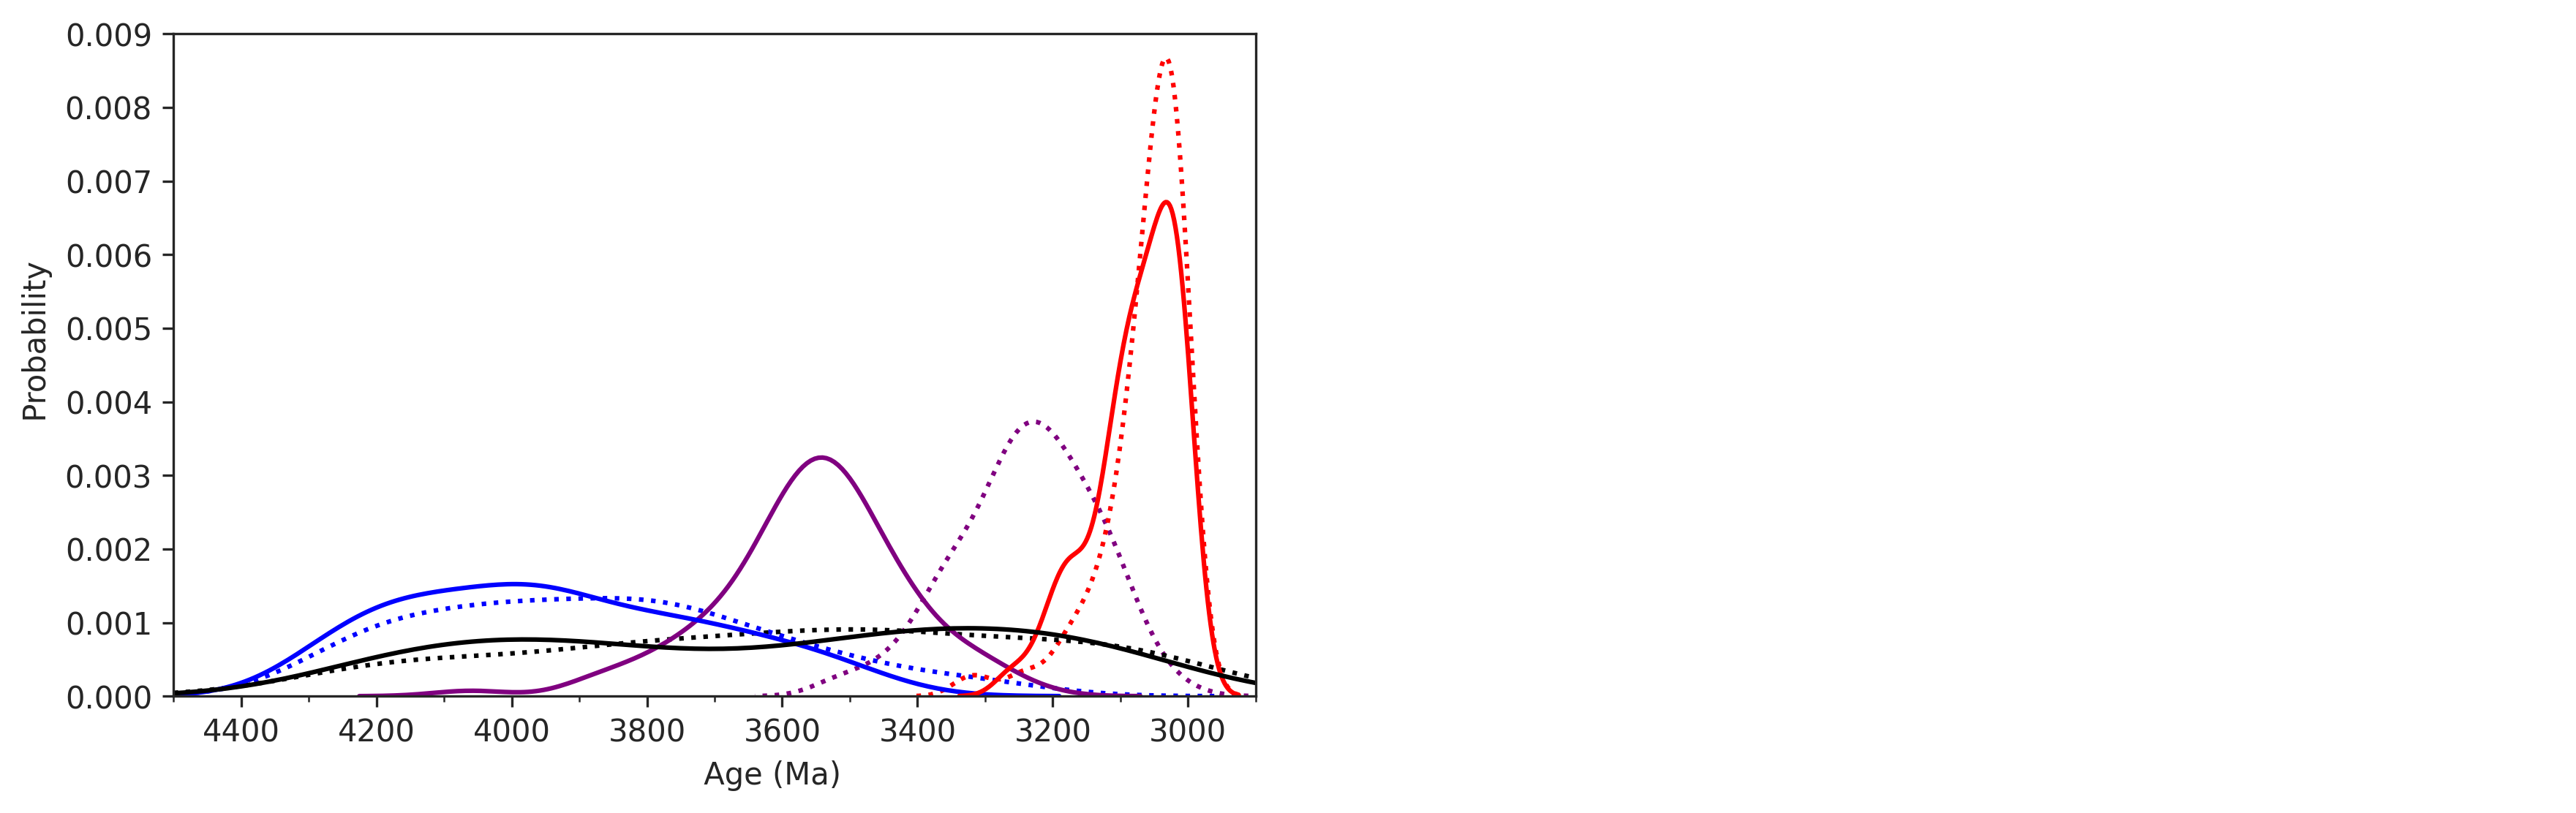

In [84]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(C_all_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_Cyano_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_euk_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(C_rootcal_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="black", **kwargs)

axes[0]=sns.kdeplot(C_all_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_Cyano_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_euk_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(C_rootcal_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="black", **kwargs)

#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.009])
### X-limits 
axes[0].set_xlim([4500,2900])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(200))
axes[1].axis('off')
#axes[0].title.set_text('Clock_sat_STEM_AGE_eukaryotic_and_Cyano_cal_UGAM_BLUE_CIR_PURPLE_LN_RED')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_BLUE_EUK_RED_ALL_PURP_DOTCIR_LINE_UGAM'+'.svg',format='svg')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_BLUE_EUK_RED_ALL_PURP_DOTCIR_LINE_UGAM'+'.png',format='png')

In [85]:
### 

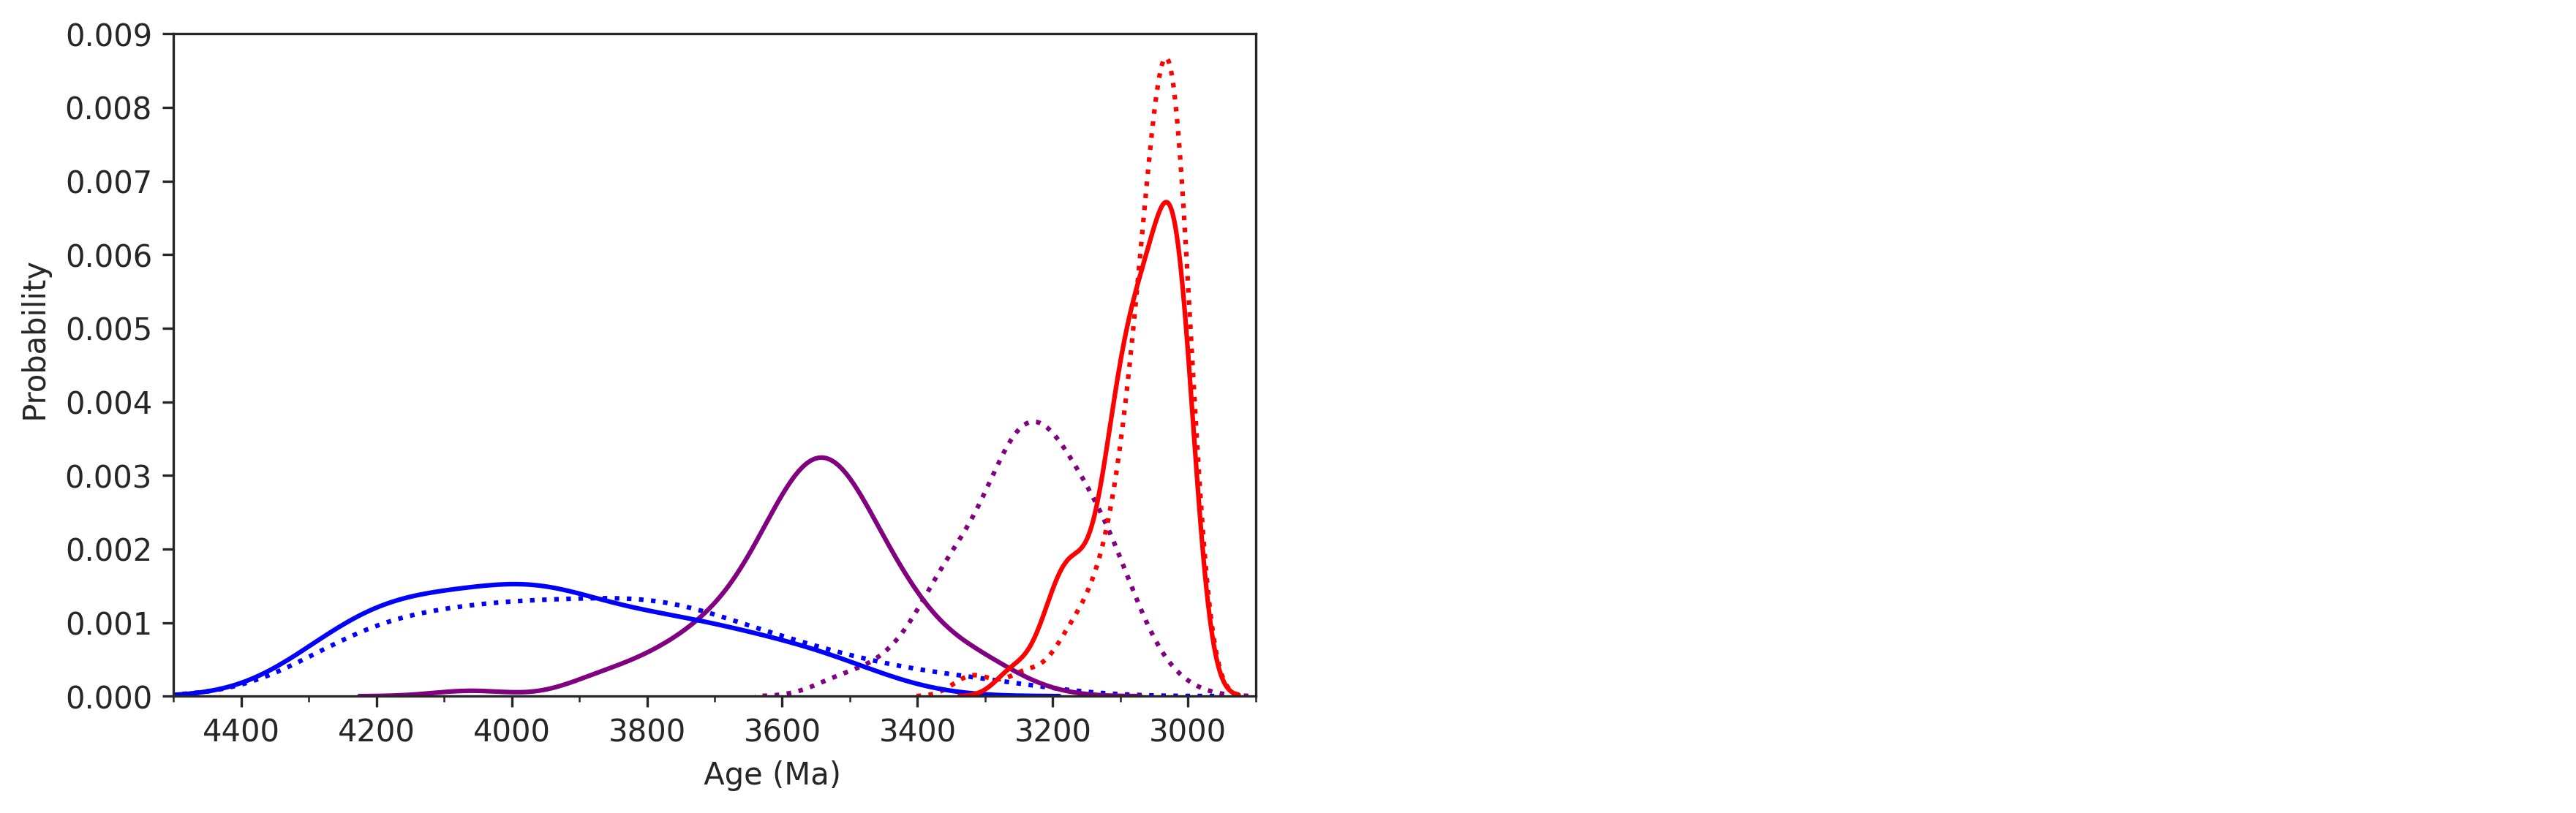

In [86]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(C_all_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_Cyano_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_euk_cals_UGAM_post_ages['401'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="red", **kwargs)

axes[0]=sns.kdeplot(C_all_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_Cyano_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_euk_cals_CIR_post_ages['401'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)

#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.009])
### X-limits 
axes[0].set_xlim([4500,2900])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(200))
axes[1].axis('off')
#axes[0].title.set_text('Clock_sat_STEM_AGE_eukaryotic_and_Cyano_cal_UGAM_BLUE_CIR_PURPLE_LN_RED')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_BLUE_EUK_RED_ALL_PURP_DOTCIR_LINE_UGAM'+'.svg',format='svg')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_BLUE_EUK_RED_ALL_PURP_DOTCIR_LINE_UGAM'+'.png',format='png')

In [87]:
np.median(C_all_cals_CIR_post_ages['401'])

3551.035

In [88]:
np.median(C_Cyano_cals_CIR_post_ages['401'])

3961.0249999999996

In [89]:
np.median(C_euk_cals_CIR_post_ages['401'])

3064.7349999999997

In [90]:
np.median(C_rootcal_CIR_post_ages['401'])

3554.67

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


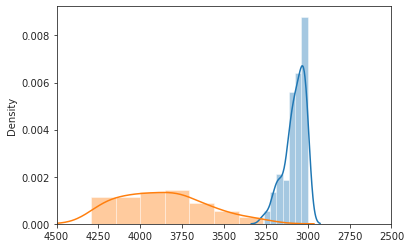

Crown Sat CIR Cals: Euk (blue) vs Cyano (red)


In [92]:
sns.distplot(C_euk_cals_CIR_post_ages['401'][0])
sns.distplot(C_Cyano_cals_UGAM_post_ages['401'])
plt.xlim(4500,2500)
plt.show() 
print('Crown Sat CIR Cals: Euk (blue) vs Cyano (red)')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

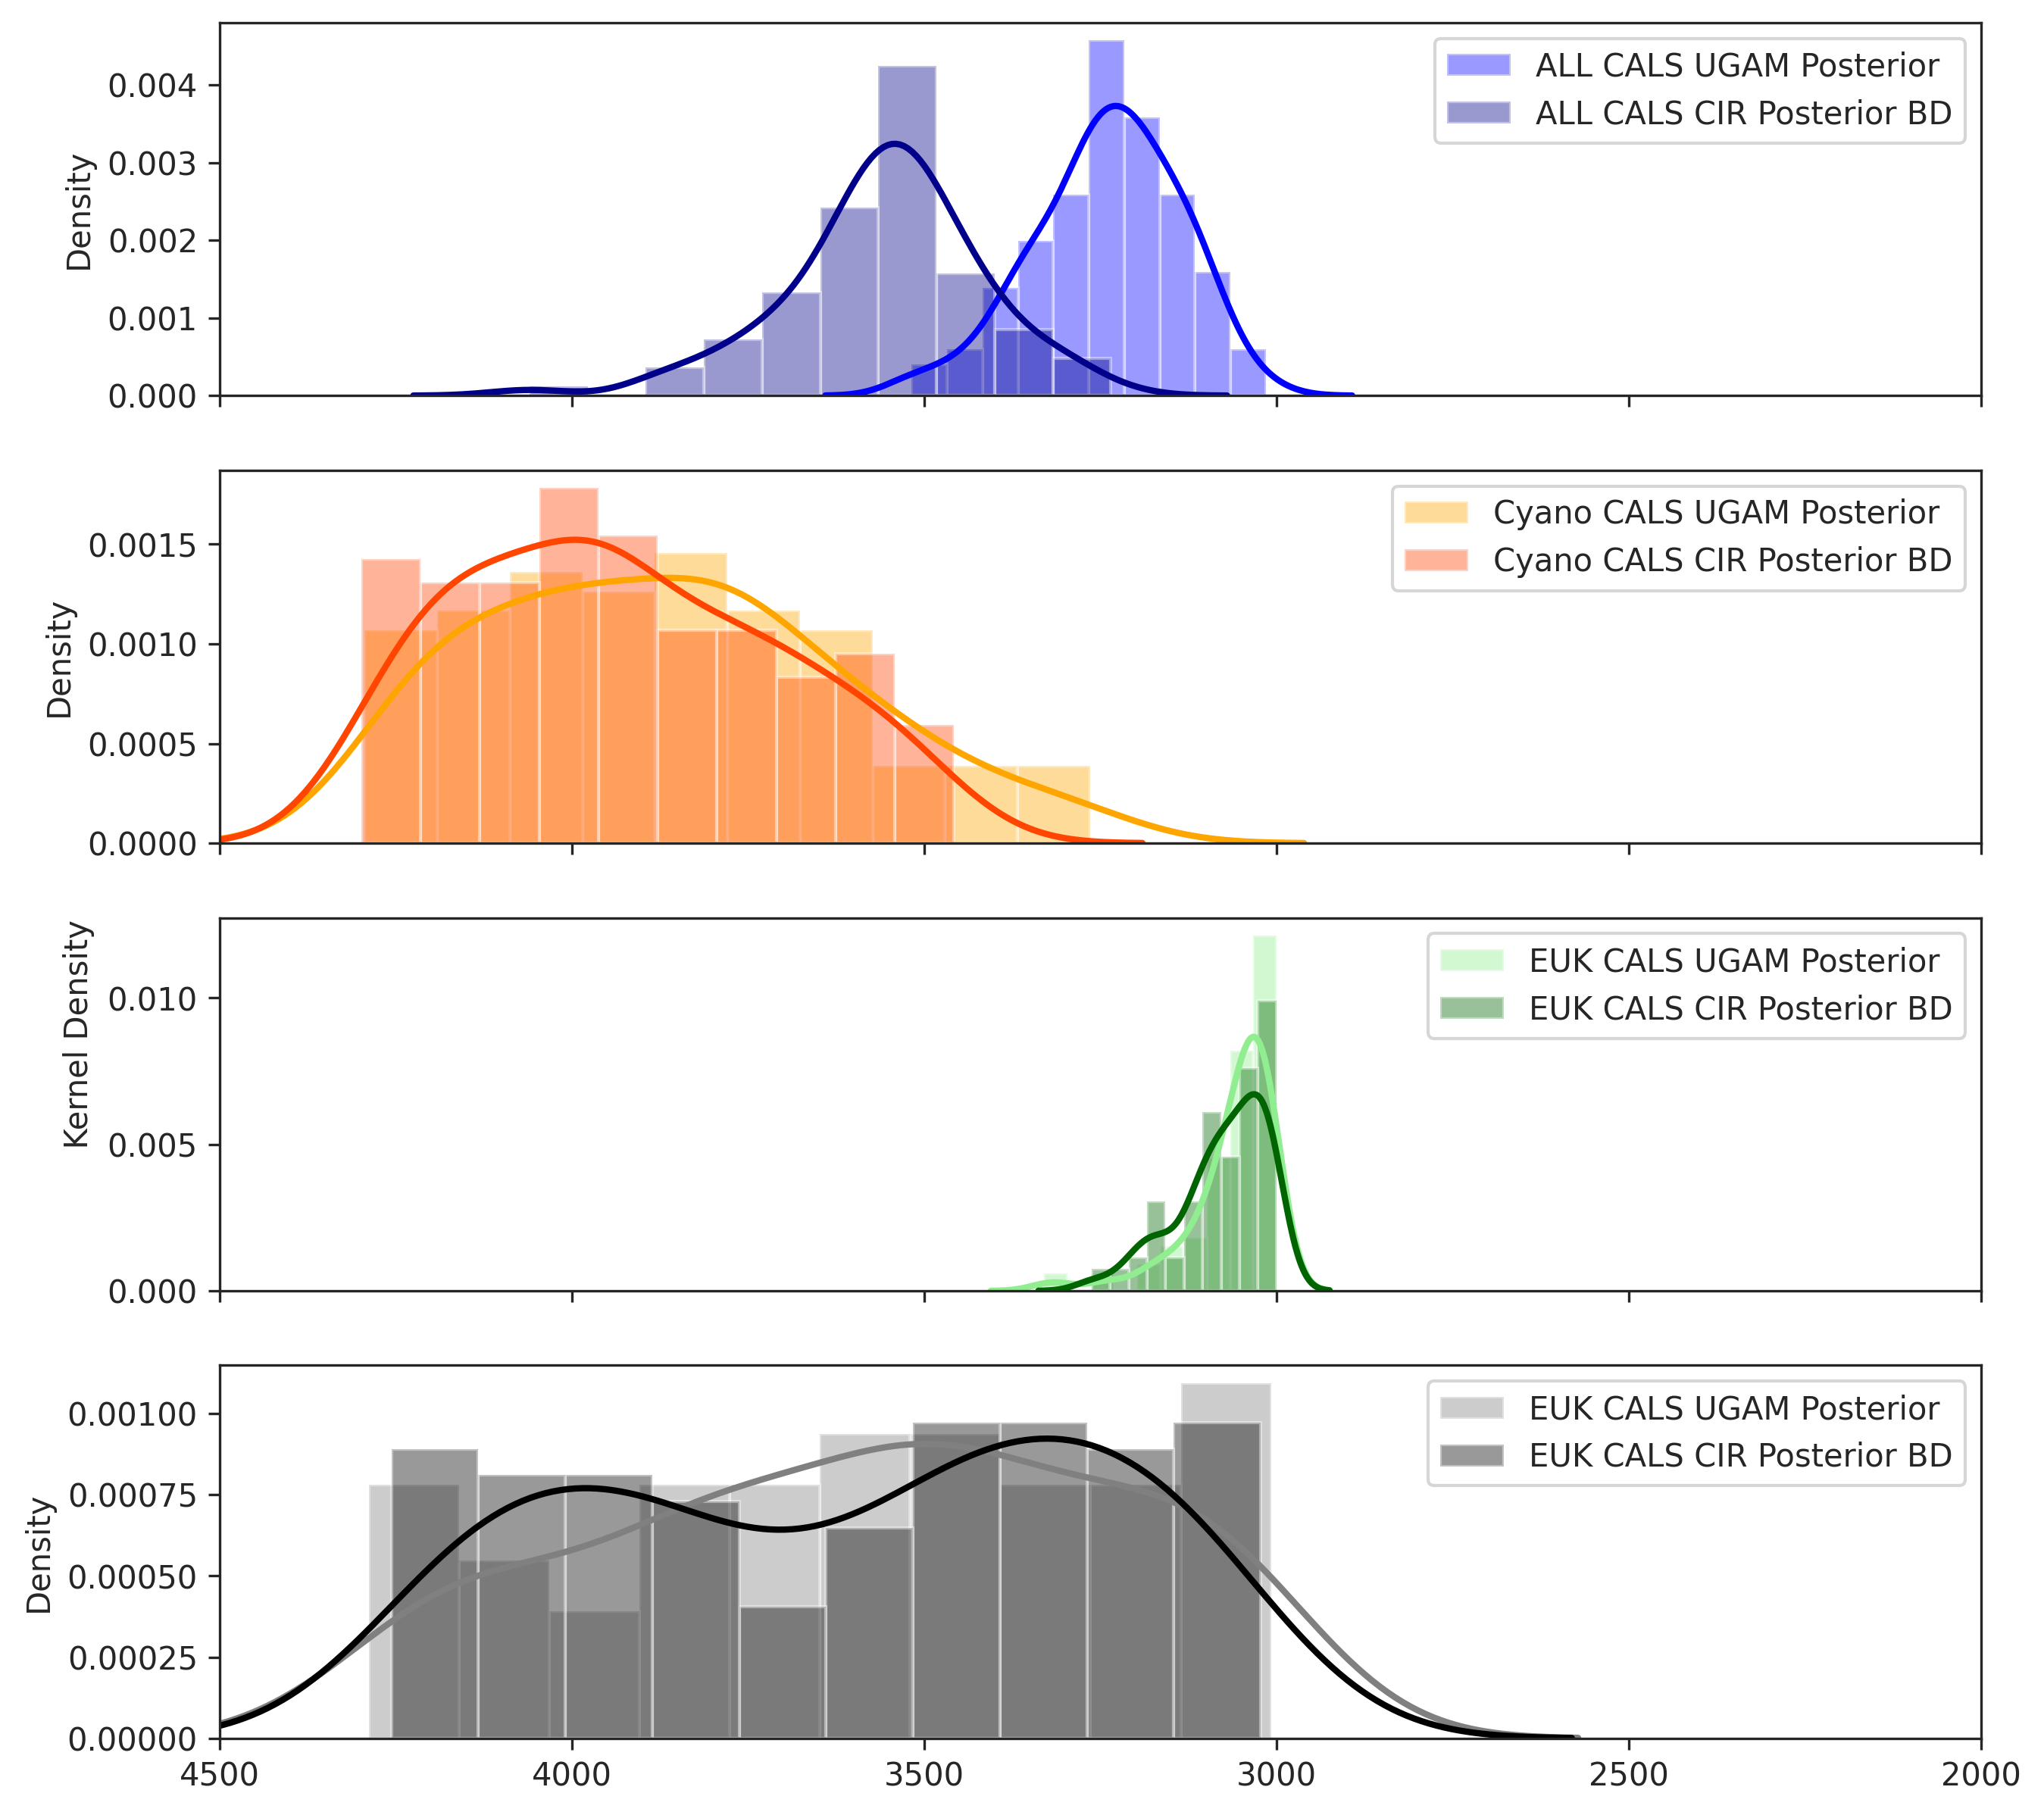

Sat Crown Age Euk Calibrations and All Models x Branch Rate Processes


In [93]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,2000)
sns.distplot(C_all_cals_UGAM_post_ages['401'], label="ALL CALS UGAM Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
sns.distplot(C_all_cals_CIR_post_ages['401'], label="ALL CALS CIR Posterior BD",bins=10,ax=axes[0],color="darkblue", **kwargs)
axes[0].legend()
sns.distplot(C_Cyano_cals_UGAM_post_ages['401'], label="Cyano CALS UGAM Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
sns.distplot(C_Cyano_cals_CIR_post_ages['401'], label="Cyano CALS CIR Posterior BD",bins=10,ax=axes[1],color="orangered", **kwargs)
axes[1].legend()
sns.distplot(C_euk_cals_UGAM_post_ages['401'], label="EUK CALS UGAM Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
sns.distplot(C_euk_cals_CIR_post_ages['401'], label="EUK CALS CIR Posterior BD",bins=10,ax=axes[2],color="darkgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
sns.distplot(C_rootcal_UGAM_post_ages['401'], label="EUK CALS UGAM Posterior",bins=10,ax=axes[3],color="grey", **kwargs)
sns.distplot(C_rootcal_CIR_post_ages['401'], label="EUK CALS CIR Posterior BD",bins=10,ax=axes[3],color="black", **kwargs)
axes[3].legend()
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_EukCalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_EukCalsByAllModels.png", format="png")
print('Sat Crown Age Euk Calibrations and All Models x Branch Rate Processes')

In [ ]:
### FIN ###